# S0. Configuration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
os.chdir('/content/drive/MyDrive/pp_kaggle_houseprices')

In [4]:
%ls

0_houseprices.ipynb  inputs/  outputs/


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tools.eval_measures import rmse #Error metrics
from statsmodels.regression.linear_model import OLS #Ordinary Least Squares
import statsmodels.api as sm # Add intercept

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#S1. EDA

## S1.1 Overview

In [7]:
house_price = pd.read_csv('inputs/train.csv', index_col=0)
house_price.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
n_variables = len(house_price.columns)
print('number of variables = ',n_variables)
print('number of rows = ', house_price.shape[0])

number of variables =  80
number of rows =  1460


In [9]:
#Missing data
missing = house_price.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True, ascending=False)

<BarContainer object of 19 artists>

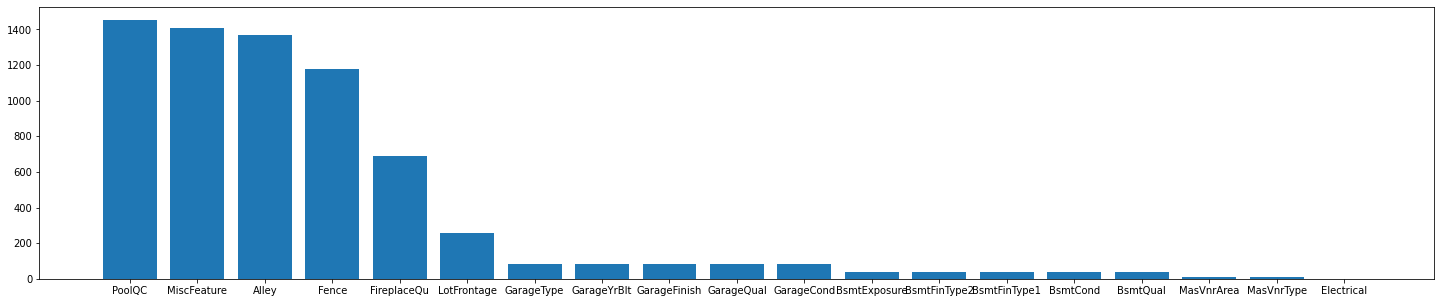

In [10]:
plt.figure(figsize=(25,5))
plt.bar(missing.index,missing.values)

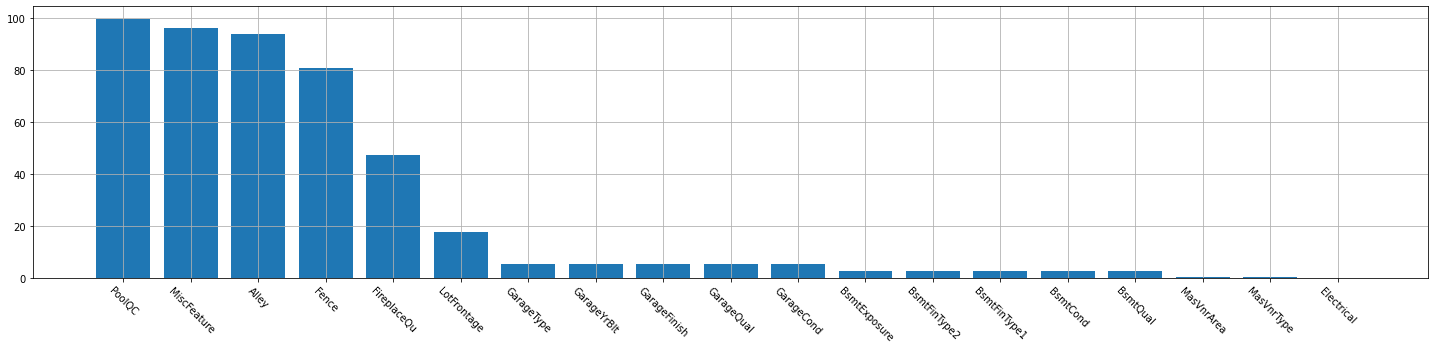

In [11]:
missing_perc = missing.map(lambda x: 100 * (x/ house_price.shape[0]))
plt.figure(figsize=(25,5))
plt.bar(missing_perc.index,missing_perc.values)
plt.xticks(rotation = -45)
plt.grid()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

The output has to be transformed


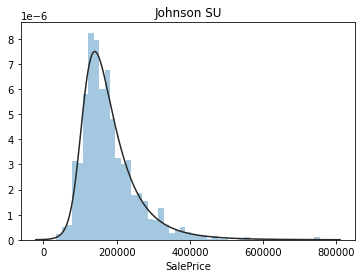

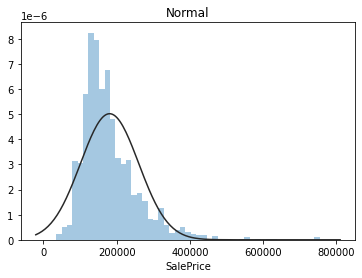

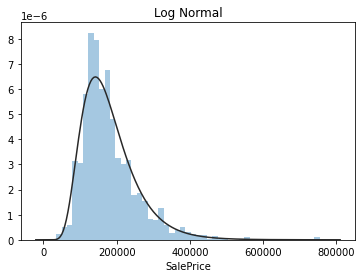

In [12]:
import scipy.stats as st #statisticval functions
y = house_price['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu) #dist. johnson, MUST GET PARAMETERS, even if it is unbounded
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)
print('The output has to be transformed')

In [13]:
quantitative = list(house_price.select_dtypes(include=[np.number]).columns)
quantitative.remove('SalePrice')
print(quantitative)
print(len(quantitative))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
36


In [14]:
qualitative = list(house_price.select_dtypes(exclude=[np.number]).columns)
print(qualitative)
print(len(qualitative))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
43


In [15]:
#normality test for quantitative variables, as none of them follows a normal dist. they must be transformed
test_normality = lambda x: st.shapiro(x.fillna(0))[1] < 0.01 # I don't identify this code line
normal = pd.DataFrame(house_price[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

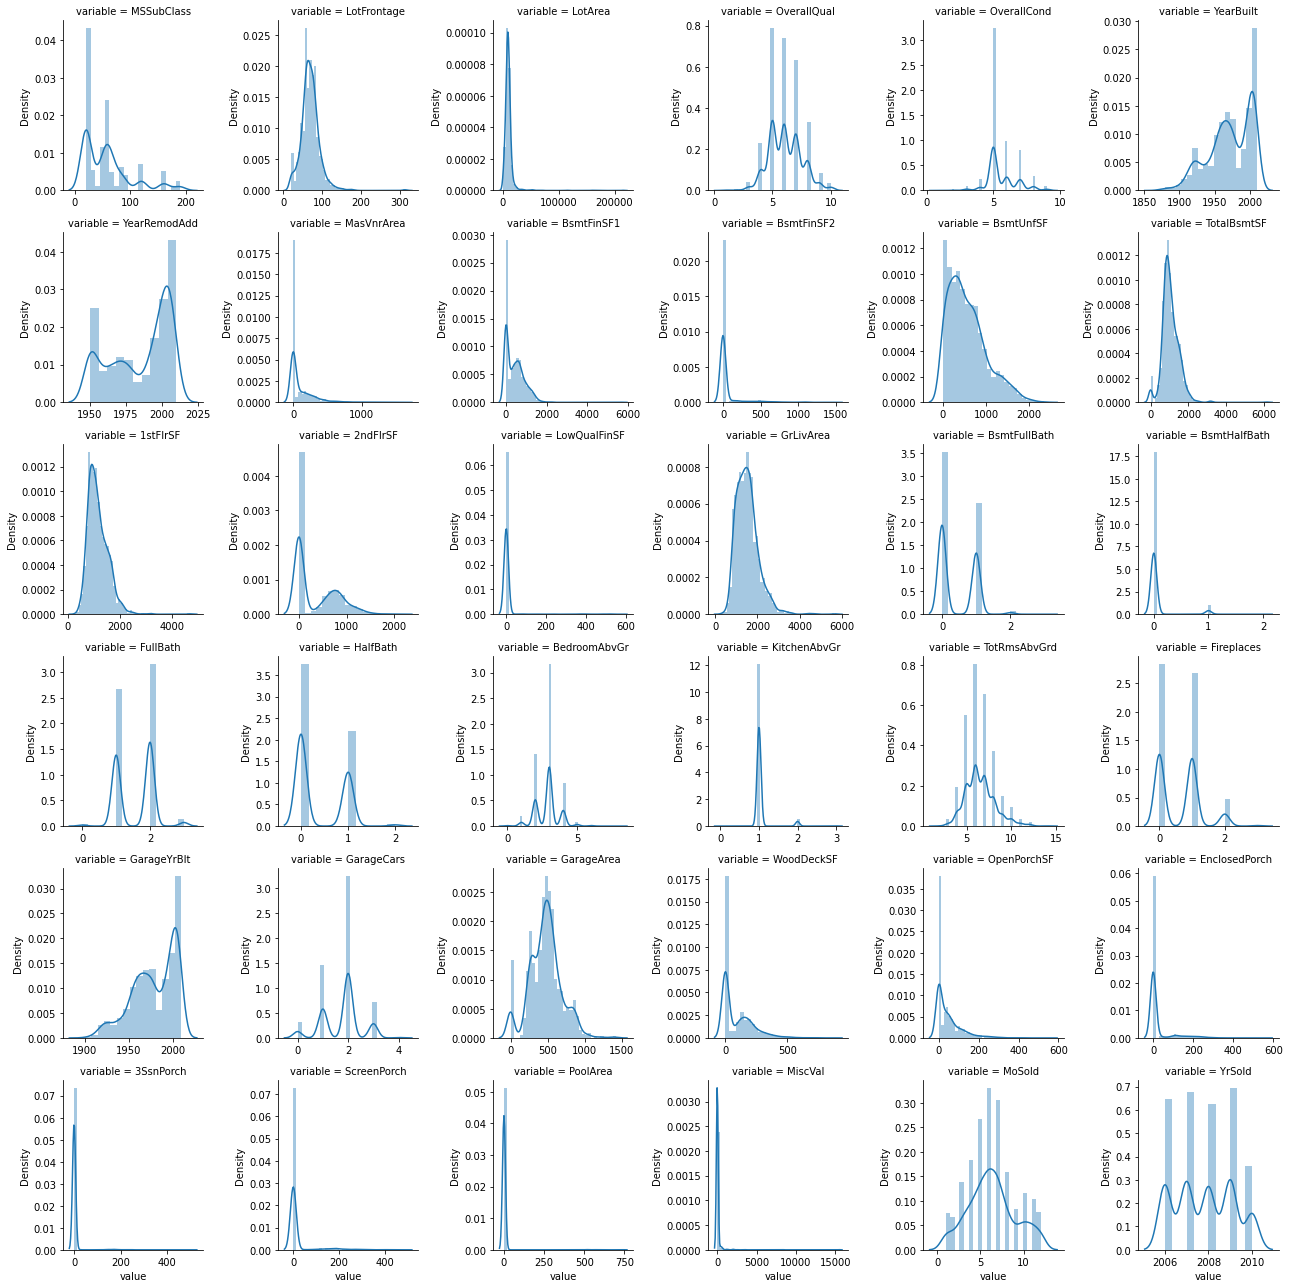

In [16]:
#must identify which variables has to be transformed with log transformation and what to do with the others
f = pd.melt(house_price, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

## S1.2 Categorical data

In [17]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

In [18]:
for c in qualitative:
    house_price[c] = house_price[c].astype('category')
    if house_price[c].isnull().any():
        house_price[c] = house_price[c].cat.add_categories(['MISSING'])
        house_price[c] = house_price[c].fillna('MISSING')

In [19]:
house_price[qualitative].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,MISSING,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,MISSING,MISSING,MISSING,WD,Normal
2,RL,Pave,MISSING,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,MISSING,MISSING,MISSING,WD,Normal
3,RL,Pave,MISSING,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,MISSING,MISSING,MISSING,WD,Normal
4,RL,Pave,MISSING,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,MISSING,MISSING,MISSING,WD,Abnorml
5,RL,Pave,MISSING,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,MISSING,MISSING,MISSING,WD,Normal


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


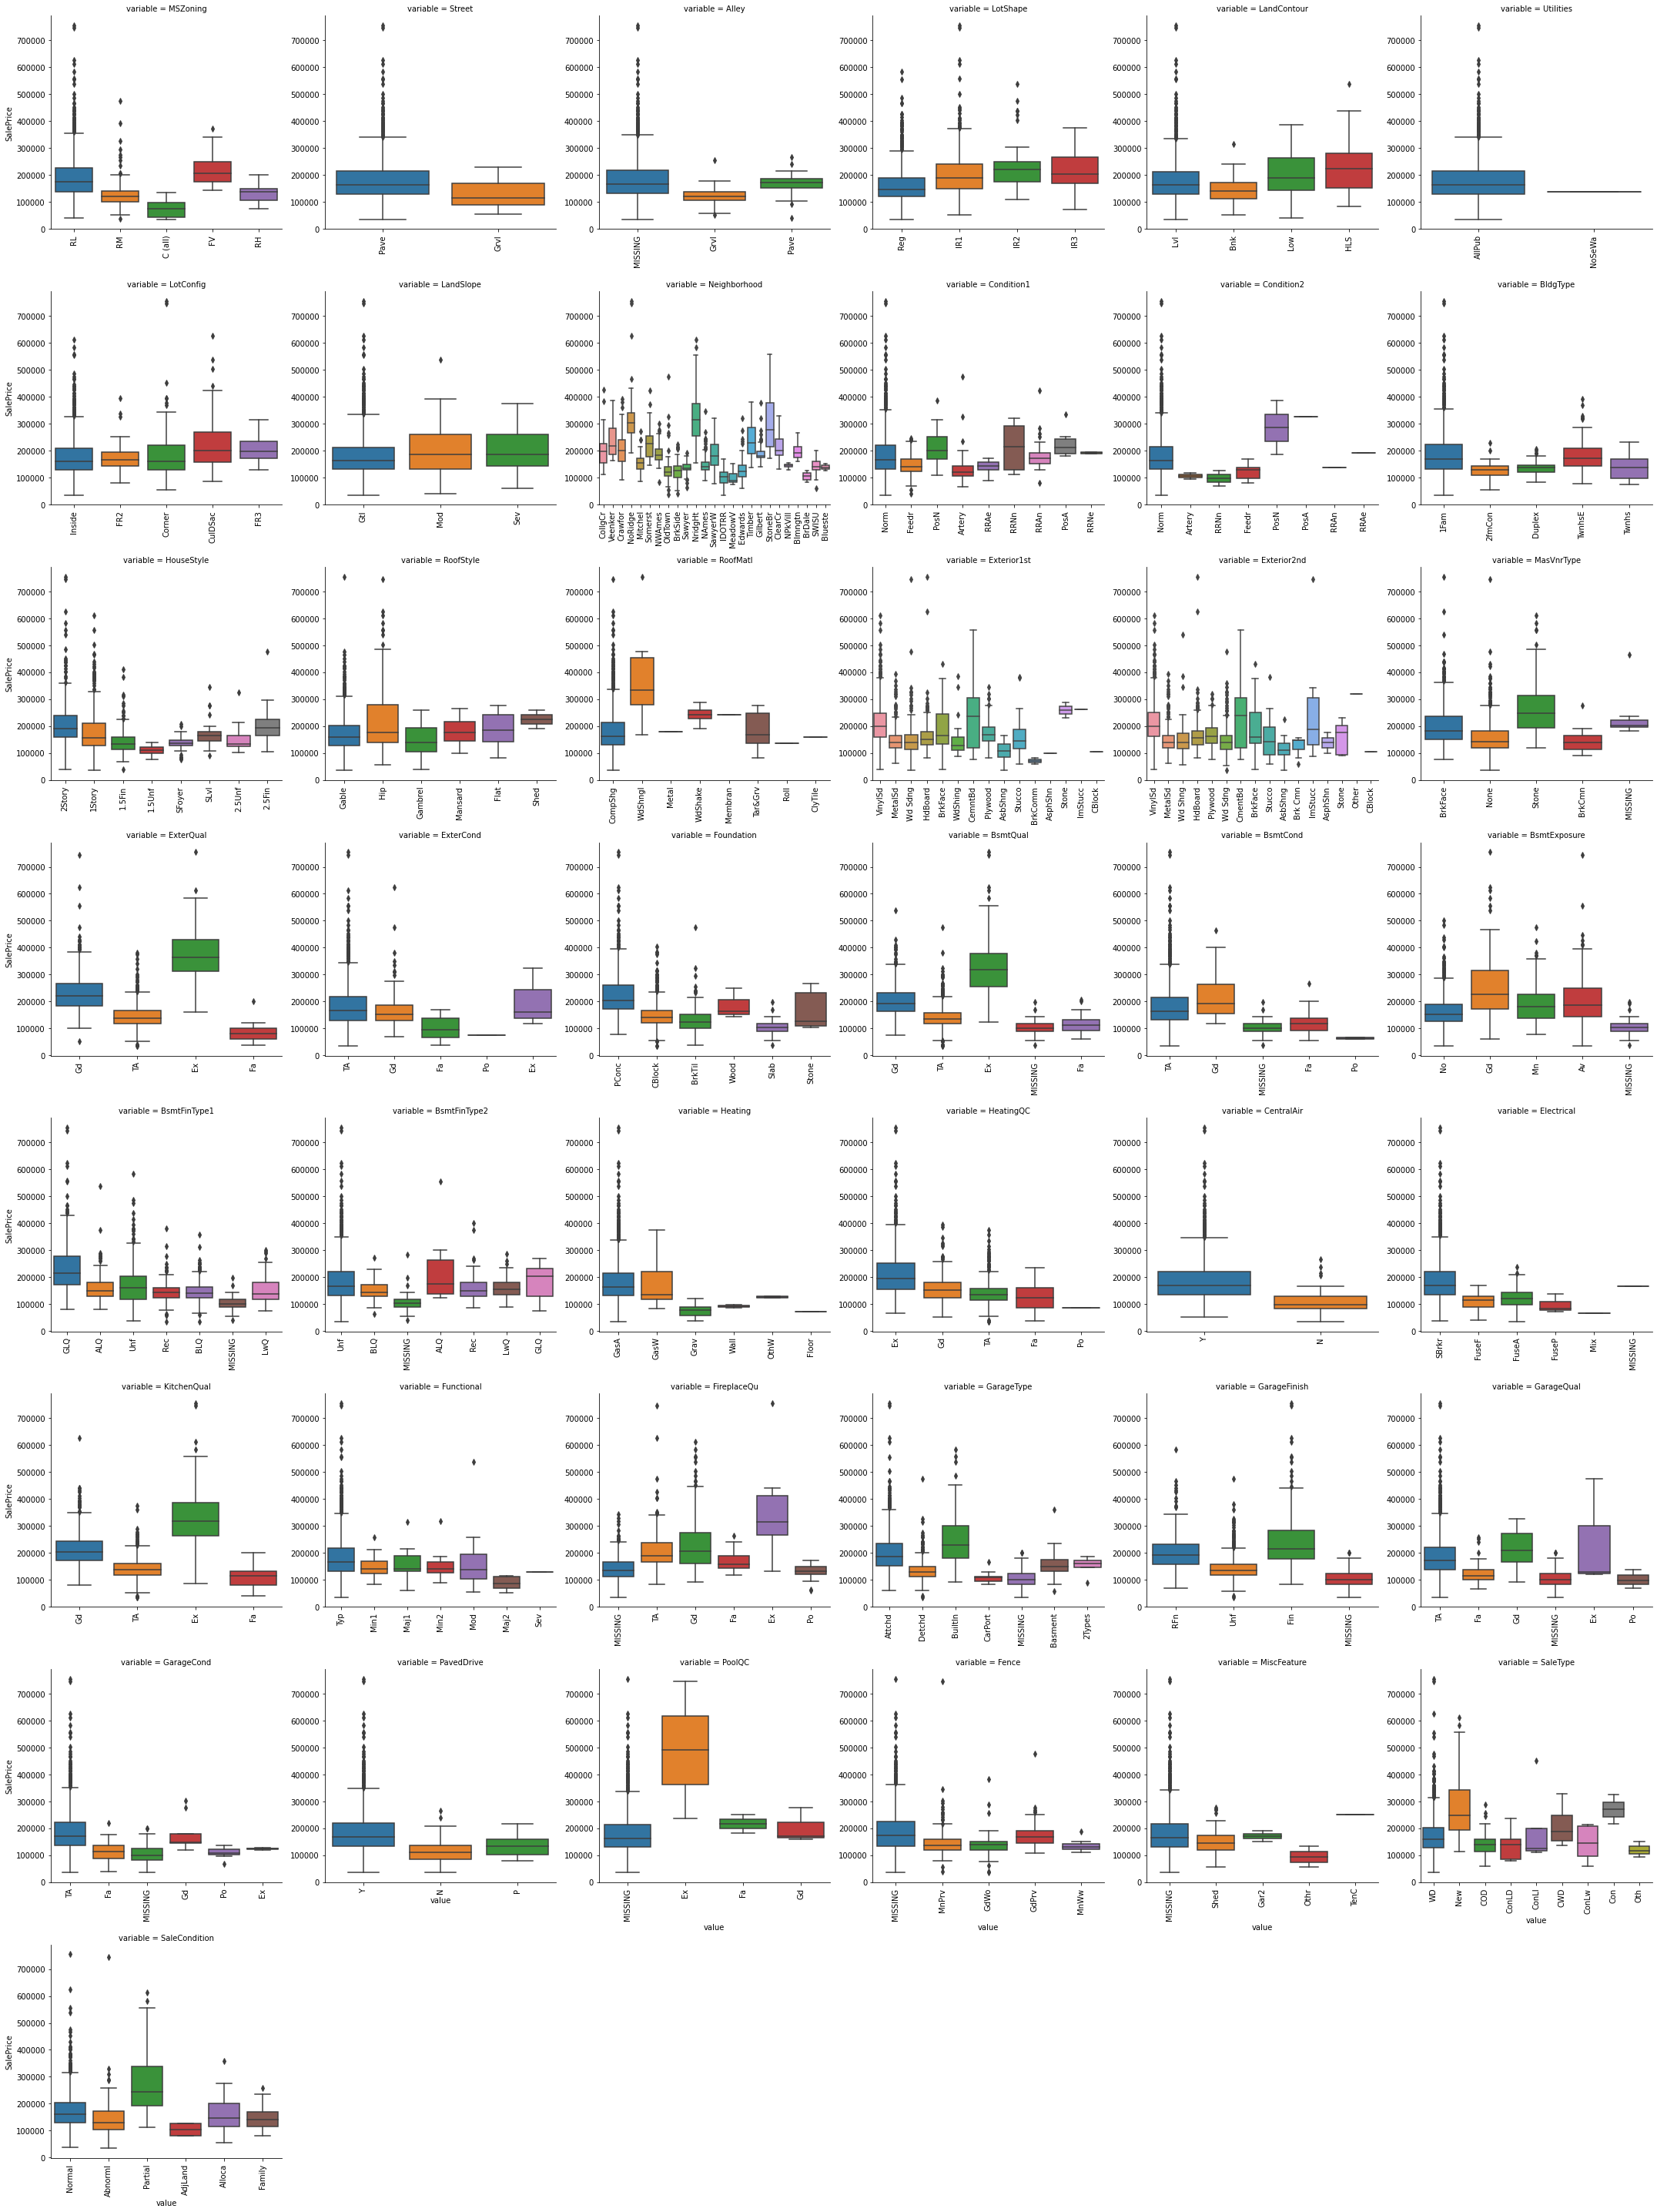

In [20]:
f = pd.melt(house_price, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

In [21]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

In [22]:
a = anova(house_price)
a['disparity'] = np.log(1./a['pval'].values)

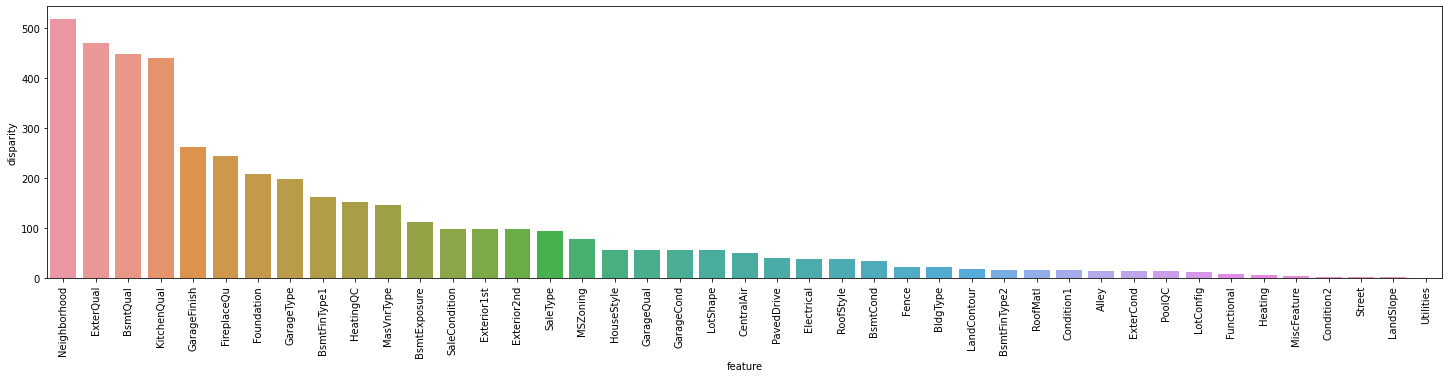

In [23]:
#Estimation of the influence of each categorical cariable on SalesPrice
plt.figure(figsize=(25,5))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [24]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [25]:
qual_encoded = []
for q in qualitative:  
    encode(house_price, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [26]:
print(list(house_price.columns))

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [27]:
house_price[['Functional','Functional_E']]

,Functional,Functional_E
Id,,
1,Typ,7.0
2,Typ,7.0
3,Typ,7.0
4,Typ,7.0
5,Typ,7.0
...,...,...
1456,Typ,7.0
1457,Min1,4.0
1458,Typ,7.0


## S1.3 Correlations

In [28]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

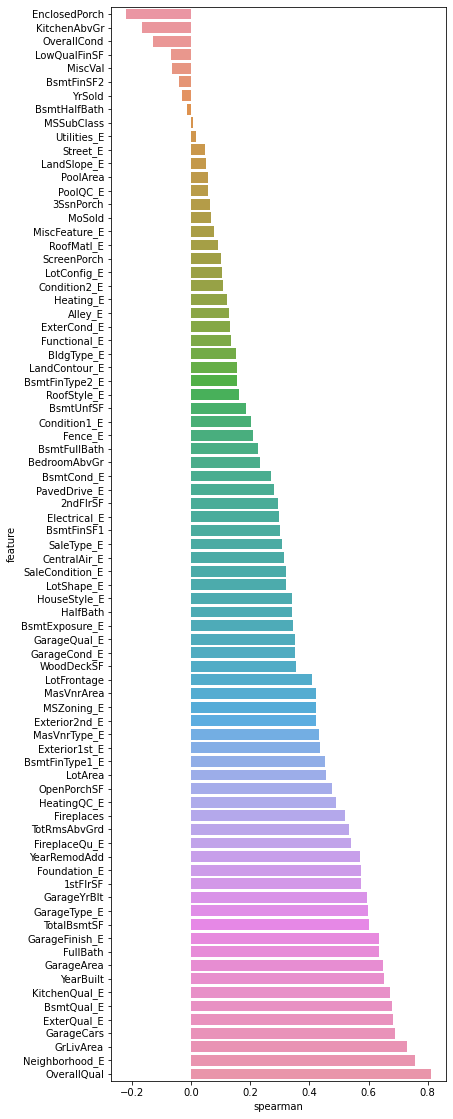

In [29]:
features = quantitative + qual_encoded
spearman(house_price, features)

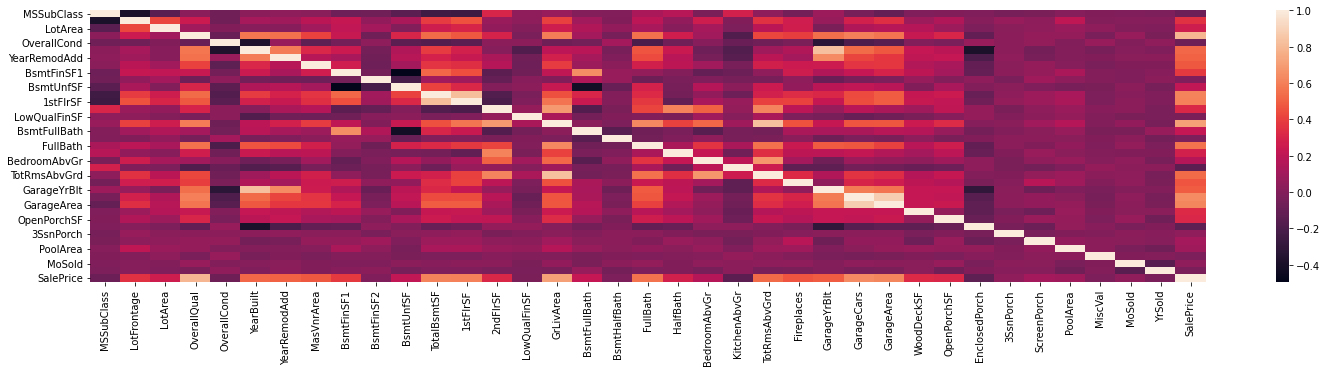

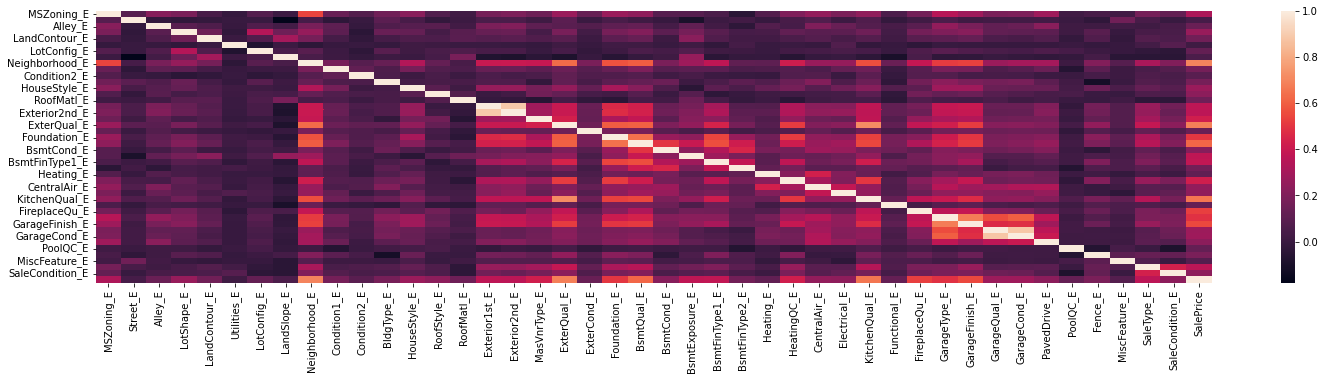

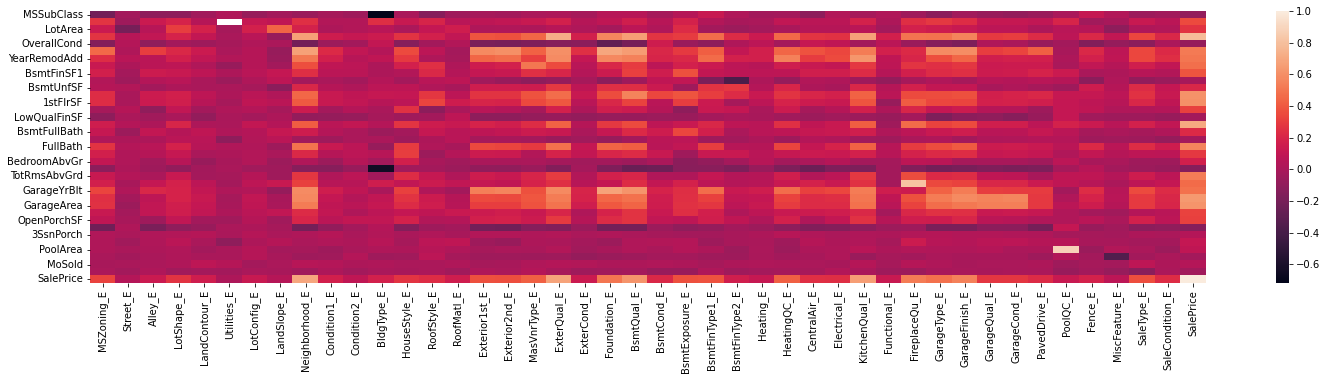

In [30]:
plt.figure(1,figsize=(25,5))
corr = house_price[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2,figsize=(25,5))
corr = house_price[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3,figsize=(25,5))
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = house_price[q1].corr(house_price[q2])
sns.heatmap(corr)

## S1.4 Pairplots

In [31]:
house_price['SalePrice'].nunique() # nunique() => count ; unique() => show

663

In [32]:
house_price['SalePrice'].value_counts()

140000    20
135000    17
155000    14
145000    14
190000    13
          ..
202665     1
164900     1
208300     1
181500     1
147500     1
Name: SalePrice, Length: 663, dtype: int64

In [33]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

In [34]:
f = pd.melt(house_price, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
print(f.nunique())
f

SalePrice     663
variable       79
value        3057
dtype: int64


,SalePrice,variable,value
0,208500,MSSubClass,60.0
1,181500,MSSubClass,20.0
2,223500,MSSubClass,60.0
3,140000,MSSubClass,70.0
4,250000,MSSubClass,60.0
...,...,...,...
115335,175000,SaleCondition_E,5.0
115336,210000,SaleCondition_E,5.0
115337,266500,SaleCondition_E,5.0
115338,142125,SaleCondition_E,5.0


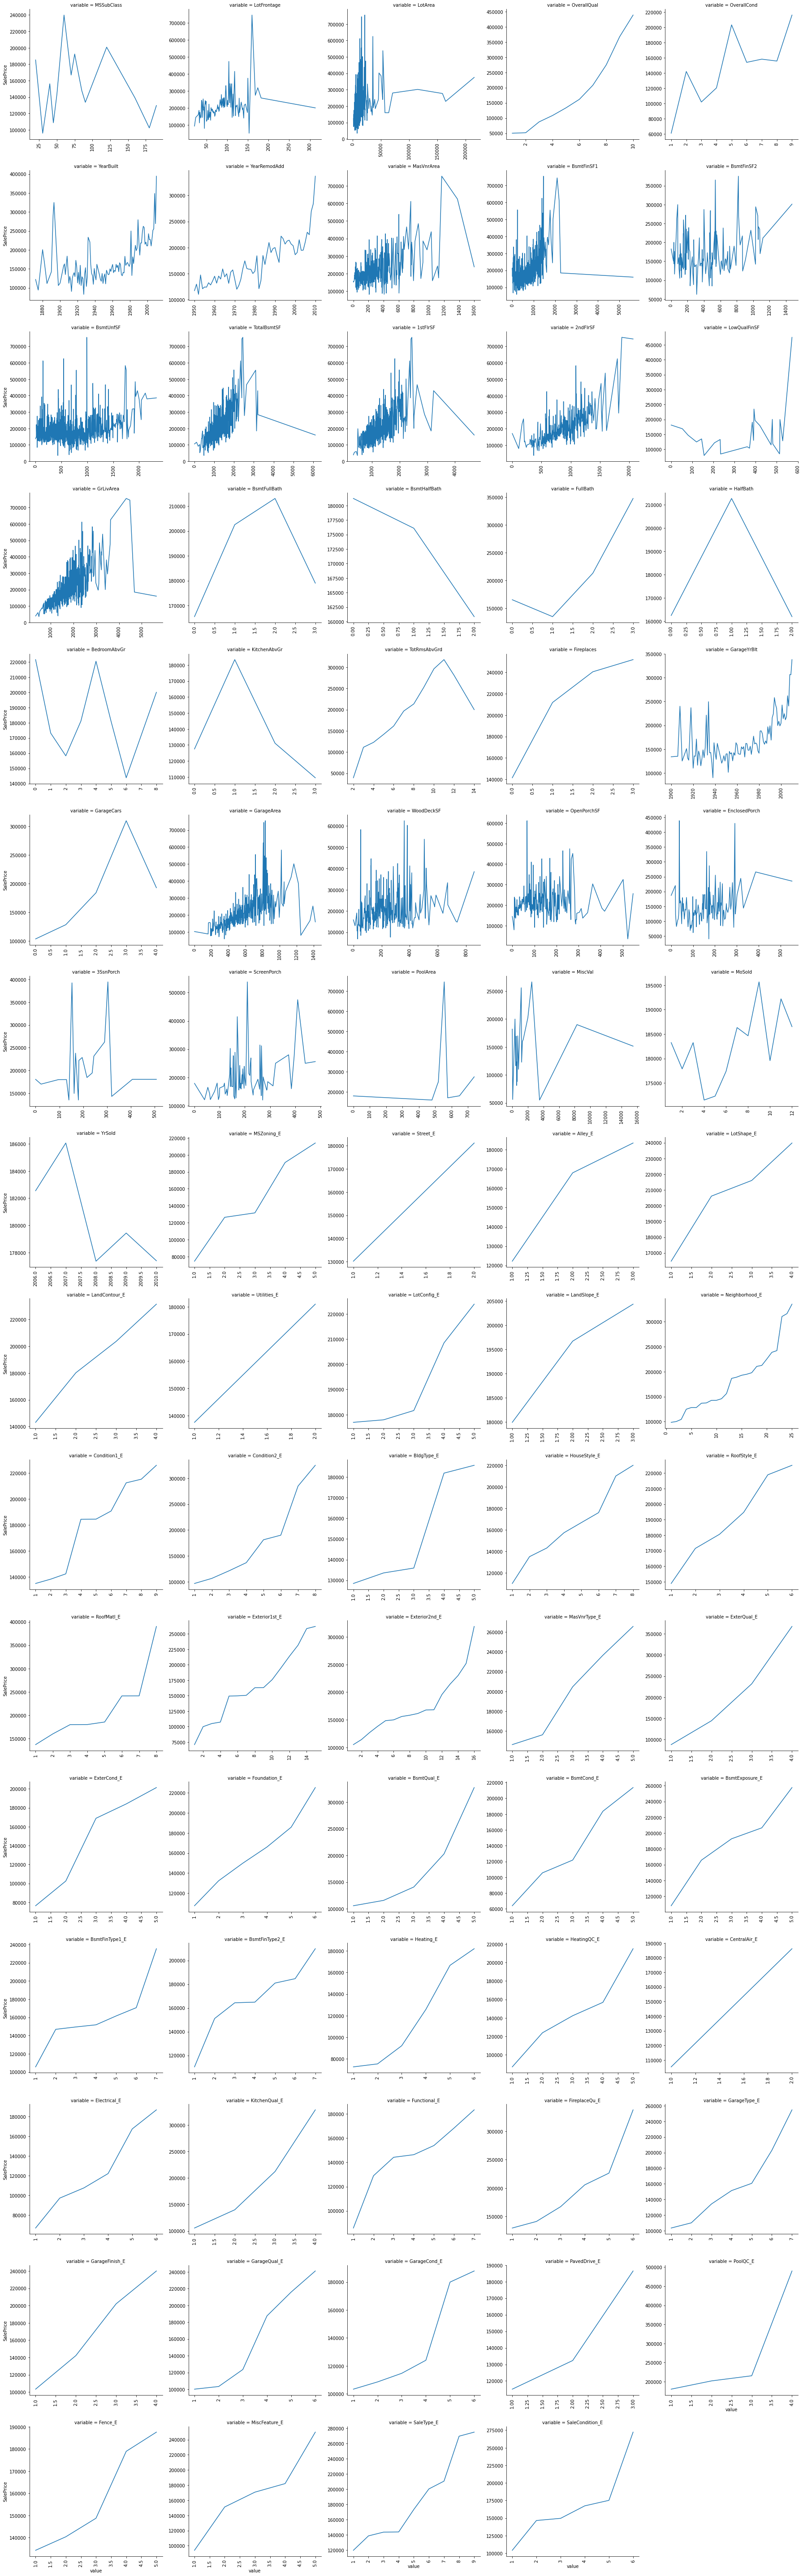

In [35]:
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False, height=5)
g = g.map(pairplot, "value", "SalePrice")

##S1.5 Price segments

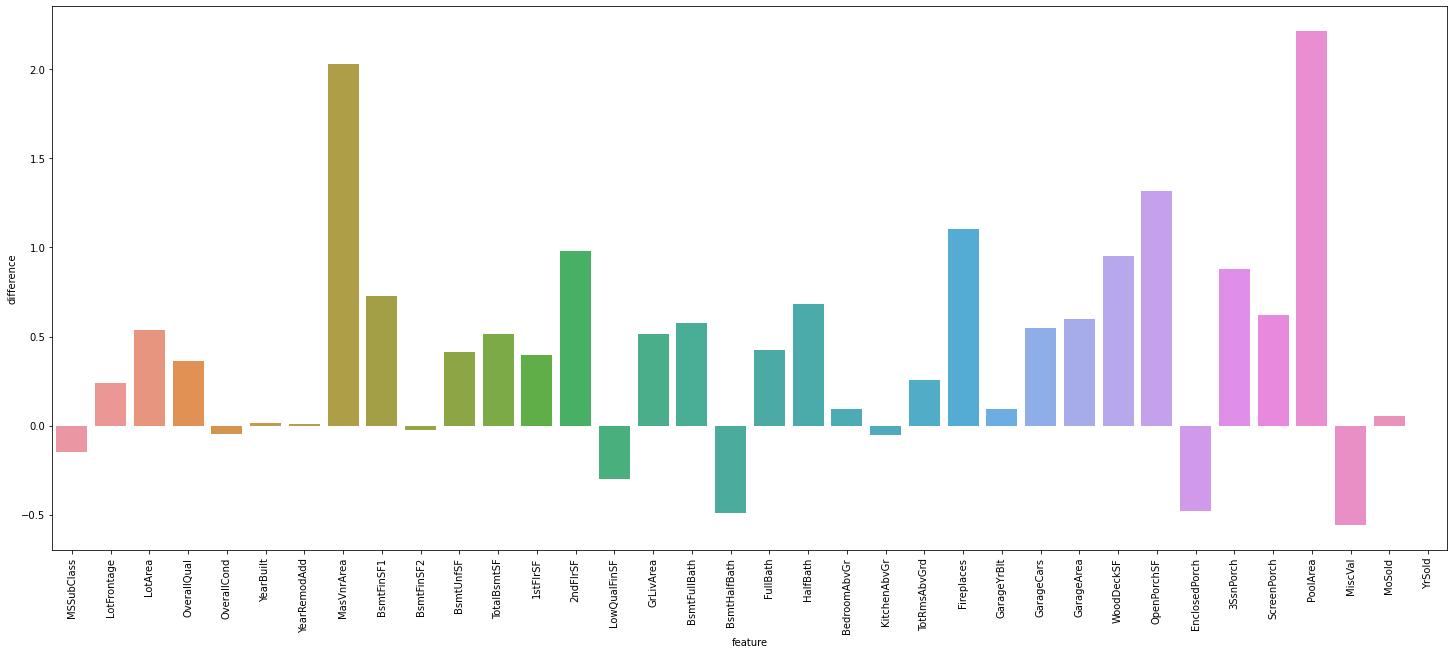

In [36]:
features = quantitative #list of the quantitative vars. 

standard = house_price[house_price['SalePrice'] < 200000]
pricey = house_price[house_price['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [ (pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean()) / (standard[f].fillna(0.).mean()) for f in features]

# a bigger or lower 'difference' value means that the variable it is important in the change of the value of the objective variable 
plt.figure(figsize=(25,10))
sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

##S1.6 Clustering

In [37]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [38]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50) # DIMENSION REDUCTION
X = house_price[features].fillna(0.).values
tsne = model.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [39]:
house_price[features].fillna(0.).head() #X values

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,3.0,2.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,2.0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0


In [40]:
std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

KMeans(n_clusters=5)

0.7498162087762895


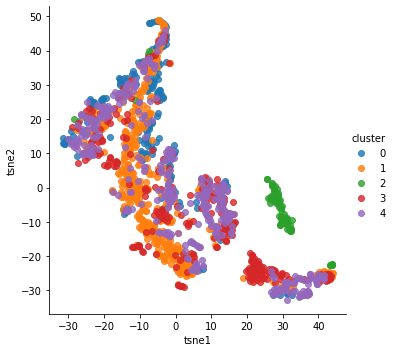

In [41]:
fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_)) #not enough clustering to make a segmented regression

##S1.7 Output transformation


In [42]:
def johnson(y):
    gamma, eta, epsilon, lbda = st.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

In [43]:
def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


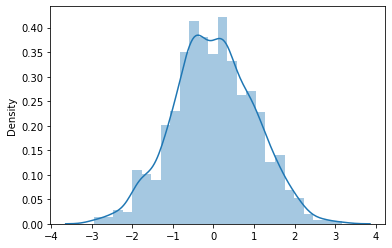

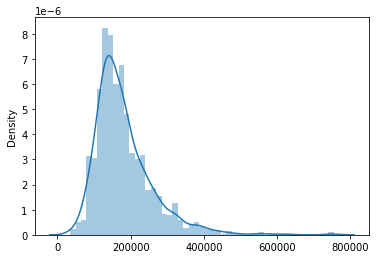

In [44]:
y = house_price['SalePrice'].values

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2) # probability of overfitting, so it is used log. IF THERE ARE MORE THAN 1500 INSTANCES THIS IS A POSIBILITY

In [45]:
yes = pd.DataFrame()
yes['y'] = y
yes['yt2'] = yt2
yes.head()

,y,yt2
0,208500,208500.0
1,181500,181500.0
2,223500,223500.0
3,140000,140000.0
4,250000,250000.0


# S2. REGRESSION

## Transform

In [46]:
def log_transform(feature):
    house_price[feature] = np.log1p(house_price[feature].values)

def quadratic(feature):
    house_price[feature+'2'] = house_price[feature]**2

In [47]:
#Logaritmic Transform
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

In [48]:
#Quadratic Transformation
quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

In [49]:
#Boolean Transformation
house_price['HasBasement'] = house_price['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
house_price['HasGarage'] = house_price['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
house_price['Has2ndFloor'] = house_price['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
house_price['HasMasVnr'] = house_price['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
house_price['HasWoodDeck'] = house_price['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
house_price['HasPorch'] = house_price['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
house_price['HasPool'] = house_price['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
house_price['IsNew'] = house_price['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [50]:
qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']

features = quantitative + qual_encoded + boolean + qdr

## 2.1 statsmodel, NO Log(y)

In [51]:
#STATSMODEL
x = house_price[features].fillna(0.)
y = house_price['SalePrice']

x = sm.add_constant(x)
lr = OLS(y, x).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     129.3
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:29:49   Log-Likelihood:                -16863.
No. Observations:                1460   AIC:                         3.392e+04
Df Residuals:                    1364   BIC:                         3.443e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.496e+06   1.55e+07     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [52]:
#deleting variables with multicollineality 
features2remove = ['MSSubClass','LotFrontage','YearBuilt','YearRemodAdd','1stFlrSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','GarageYrBlt',
'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','MiscVal','MoSold','YrSold','MSZoning_E','Alley_E','LotShape_E','LandContour_E','LotConfig_E',
'LandSlope_E','BldgType_E','HouseStyle_E','RoofStyle_E','Exterior1st_E','Exterior2nd_E','MasVnrType_E','ExterQual_E','ExterCond_E','Foundation_E','BsmtCond_E',
'BsmtFinType1_E','Heating_E','HeatingQC_E','CentralAir_E','Electrical_E','FireplaceQu_E',  'GarageType_E','GarageFinish_E','GarageQual_E','GarageCond_E','PavedDrive_E','Fence_E',
'MiscFeature_E','HasGarage','HasWoodDeck','HasPorch','IsNew','YearBuilt2','YearRemodAdd2']

features2 = [element for element in features if element not in features2remove]
print(features2)

['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Street_E', 'Utilities_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'RoofMatl_E', 'BsmtQual_E', 'BsmtExposure_E', 'BsmtFinType2_E', 'KitchenQual_E', 'Functional_E', 'PoolQC_E', 'SaleType_E', 'SaleCondition_E', 'HasBasement', 'Has2ndFloor', 'HasMasVnr', 'HasPool', 'OverallQual2', 'TotalBsmtSF2', '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']


In [53]:
x2 = house_price[features2].fillna(0.)
y = house_price['SalePrice']

x2 = sm.add_constant(x2)
lr = OLS(y, x2).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     278.4
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:29:49   Log-Likelihood:                -16904.
No. Observations:                1460   AIC:                         3.390e+04
Df Residuals:                    1416   BIC:                         3.413e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9.076e+05   3.55e+05     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
#deleting variables with multicollineality 
features2remove =  ['BedroomAbvGr','Utilities_E','Neighborhood_E']
features3 = [element for element in features2 if element not in features2remove]
print(features3)

['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Street_E', 'Condition1_E', 'Condition2_E', 'RoofMatl_E', 'BsmtQual_E', 'BsmtExposure_E', 'BsmtFinType2_E', 'KitchenQual_E', 'Functional_E', 'PoolQC_E', 'SaleType_E', 'SaleCondition_E', 'HasBasement', 'Has2ndFloor', 'HasMasVnr', 'HasPool', 'OverallQual2', 'TotalBsmtSF2', '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']


In [55]:
x3 = house_price[features3].fillna(0.)
y = house_price['SalePrice']

x3 = sm.add_constant(x3)
lr = OLS(y, x3).fit()
print(lr.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     297.9
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:29:49   Log-Likelihood:                -16909.
No. Observations:                1460   AIC:                         3.390e+04
Df Residuals:                    1419   BIC:                         3.412e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.112e+06   3.49e+05     

In [56]:
def error_rmse(actual, predicted):
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [57]:
y_pred = lr.predict(x3)

In [58]:
error_rmse(y, y_pred)

25906.25197137457

In [59]:
y_pred

Id
1       205068.168762
2       215855.320093
3       208355.641275
4       185468.945941
5       309547.641208
            ...      
1456    164126.181415
1457    207769.249593
1458    259638.828999
1459    139977.297335
1460    137521.756532
Length: 1460, dtype: float64

In [60]:
#This file contains the predicted Sale Price of a house for the train.csv file.
# It was used the statsmodel.OLS regression model

In [61]:
y_pred.name = 'SalePrice'
y_pred.to_csv('outputs/output.csv')

##S2.1B Test Data

In [62]:
hp_test = pd.read_csv('inputs/test.csv', index_col=0)
hp_test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [72]:
for c in qualitative:
    hp_test[c] = hp_test[c].astype('category')
    if hp_test[c].isnull().any():
        hp_test[c] = hp_test[c].cat.add_categories(['MISSING'])
        hp_test[c] = hp_test[c].fillna('MISSING')

In [73]:
hp_test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,MISSING,Reg,Lvl,AllPub,Inside,...,120,0,MISSING,MnPrv,MISSING,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,MISSING,IR1,Lvl,AllPub,Corner,...,0,0,MISSING,MISSING,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,MISSING,IR1,Lvl,AllPub,Inside,...,0,0,MISSING,MnPrv,MISSING,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,MISSING,IR1,Lvl,AllPub,Inside,...,0,0,MISSING,MISSING,MISSING,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,MISSING,IR1,HLS,AllPub,Inside,...,144,0,MISSING,MISSING,MISSING,0,1,2010,WD,Normal


In [75]:
#Aquí vamos
def encode_test(frame, test_dataframe,feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering.head())
    ordering = ordering['ordering'].to_dict()
    #print(ordering)

    for cat, o in ordering.items():
        test_dataframe.loc[test_dataframe[feature] == cat, feature+'_E'] = o

In [77]:
qual_encoded = []
for q in qualitative:  
    encode_test(house_price, hp_test, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [80]:
hp_test[qual_encoded].head()

,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
Id,,,,,,,,,,,,,,,,,,,,,
1461,3.0,2.0,3.0,1.0,2.0,2.0,1.0,1.0,11.0,3.0,...,6.0,2.0,4.0,6.0,3.0,1.0,3.0,4.0,5.0,5.0
1462,4.0,2.0,3.0,2.0,2.0,2.0,3.0,1.0,11.0,5.0,...,6.0,2.0,4.0,6.0,3.0,1.0,5.0,3.0,5.0,5.0
1463,4.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,15.0,5.0,...,6.0,4.0,4.0,6.0,3.0,1.0,3.0,4.0,5.0,5.0
1464,4.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,15.0,5.0,...,6.0,4.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
1465,4.0,2.0,3.0,2.0,4.0,2.0,1.0,1.0,23.0,5.0,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0


In [82]:
#General Transformation
def log_transform_gral(frame, feature):
    frame[feature] = np.log1p(frame[feature].values)

def quadratic_gral(frame, feature):
    frame[feature+'2'] = frame[feature]**2

In [83]:
#Logaritmic Transform
log_transform_gral(hp_test,'GrLivArea')
log_transform_gral(hp_test,'1stFlrSF')
log_transform_gral(hp_test,'2ndFlrSF')
log_transform_gral(hp_test,'TotalBsmtSF')
log_transform_gral(hp_test,'LotArea')
log_transform_gral(hp_test,'LotFrontage')
log_transform_gral(hp_test,'KitchenAbvGr')
log_transform_gral(hp_test,'GarageArea')

In [84]:
#Quadratic Transformation
quadratic_gral(hp_test,'OverallQual')
quadratic_gral(hp_test,'YearBuilt')
quadratic_gral(hp_test,'YearRemodAdd')
quadratic_gral(hp_test,'TotalBsmtSF')
quadratic_gral(hp_test,'2ndFlrSF')
quadratic_gral(hp_test,'Neighborhood_E')
quadratic_gral(hp_test,'RoofMatl_E')
quadratic_gral(hp_test,'GrLivArea')

In [85]:
#Boolean Transformation
hp_test['HasBasement'] = hp_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
hp_test['HasGarage'] = hp_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
hp_test['Has2ndFloor'] = hp_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
hp_test['HasMasVnr'] = hp_test['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
hp_test['HasWoodDeck'] = hp_test['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
hp_test['HasPorch'] = hp_test['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
hp_test['HasPool'] = hp_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
hp_test['IsNew'] = hp_test['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [89]:
x_test = hp_test[features3].fillna(0.)
x_test = sm.add_constant(x_test)
y_test_pred = lr.predict(x_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [90]:
y_test_pred.name = 'SalePrice'
y_test_pred.to_csv('outputs/output.csv') #KAGGLE: RMSE=0.74376, 3811/3949

## 2.2 Statsmodel Log()

In [91]:
x = house_price[features].fillna(0.)
y = house_price['SalePrice']

x = sm.add_constant(x)
lr = OLS(np.log(y), x).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     176.1
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:53:12   Log-Likelihood:                 1155.7
No. Observations:                1460   AIC:                            -2119.
Df Residuals:                    1364   BIC:                            -1612.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -36.9604     67.592     

In [92]:
#deleting variables with multicollineality 
features2remove = ['MSSubClass','LotFrontage','OverallQual','YearBuilt','YearRemodAdd','1stFlrSF',
'2ndFlrSF','LowQualFinSF','GrLivArea','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
'GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','3SsnPorch','MiscVal','MoSold',
'YrSold','Alley_E','LotShape_E','LandContour_E','LandSlope_E','Neighborhood_E','BldgType_E',
'RoofStyle_E','Exterior1st_E','Exterior2nd_E','MasVnrType_E','ExterQual_E','BsmtQual_E',
'BsmtCond_E','BsmtFinType1_E','Heating_E','Electrical_E','FireplaceQu_E','GarageType_E',
'GarageQual_E','GarageCond_E','PavedDrive_E','Fence_E','MiscFeature_E','SaleType_E',
'HasGarage','Has2ndFloor','HasWoodDeck','HasPorch','IsNew','YearBuilt2','YearRemodAdd2',
'2ndFlrSF2','GrLivArea2'
]

features2 = [element for element in features if element not in features2remove]
print(features2)

['LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MSZoning_E', 'Street_E', 'Utilities_E', 'LotConfig_E', 'Condition1_E', 'Condition2_E', 'HouseStyle_E', 'RoofMatl_E', 'ExterCond_E', 'Foundation_E', 'BsmtExposure_E', 'BsmtFinType2_E', 'HeatingQC_E', 'CentralAir_E', 'KitchenQual_E', 'Functional_E', 'GarageFinish_E', 'PoolQC_E', 'SaleCondition_E', 'HasBasement', 'HasMasVnr', 'HasPool', 'OverallQual2', 'TotalBsmtSF2', 'Neighborhood_E2', 'RoofMatl_E2']


In [93]:
x2 = house_price[features2].fillna(0.)
y = house_price['SalePrice']

x2 = sm.add_constant(x2)
lr = OLS(np.log(y), x2).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     312.3
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:53:14   Log-Likelihood:                 951.65
No. Observations:                1460   AIC:                            -1819.
Df Residuals:                    1418   BIC:                            -1597.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.4511      0.344     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [94]:
#deleting variables with multicollineality 
features2remove =  ['EnclosedPorc','Condition2_E','HouseStyle_E','RoofMatl_E','HasMasVnr','RoofMatl_E2','EnclosedPorch']
features3 = [element for element in features2 if element not in features2remove]
print(features3)

['LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'ScreenPorch', 'PoolArea', 'MSZoning_E', 'Street_E', 'Utilities_E', 'LotConfig_E', 'Condition1_E', 'ExterCond_E', 'Foundation_E', 'BsmtExposure_E', 'BsmtFinType2_E', 'HeatingQC_E', 'CentralAir_E', 'KitchenQual_E', 'Functional_E', 'GarageFinish_E', 'PoolQC_E', 'SaleCondition_E', 'HasBasement', 'HasPool', 'OverallQual2', 'TotalBsmtSF2', 'Neighborhood_E2']


In [95]:
x3 = house_price[features3].fillna(0.)
y = house_price['SalePrice']

x3 = sm.add_constant(x3)
lr = OLS(np.log(y), x3).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     363.4
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:53:14   Log-Likelihood:                 944.54
No. Observations:                1460   AIC:                            -1817.
Df Residuals:                    1424   BIC:                            -1627.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.2138      0.314     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [96]:
def error(actual, predicted):
    actual = np.log(actual)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [97]:
y_pred = lr.predict(x3)

In [98]:
error(y, y_pred)

0.126706589036756

## S2.2B Test Data

In [100]:
x_test = hp_test[features3].fillna(0.)
x_test = sm.add_constant(x_test)
y_test_pred = lr.predict(x_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [109]:
y_test_pred = np.exp(y_test_pred).astype(int)
y_test_pred

Id
1461    116474
1462    160335
1463    164338
1464    195821
1465    210729
         ...  
2915     83114
2916     79868
2917    175091
2918    122364
2919    236294
Length: 1459, dtype: int64

In [110]:
y_test_pred.name = 'SalePrice'
y_test_pred.to_csv('outputs/output_log.csv') #KAGGLE: RMSE=0.16653, 2637/3949